In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
import xrft
import matplotlib.colors as colors
import matplotlib
from scipy import stats
import matplotlib as mpl

In [2]:
import nc_time_axis

In [3]:
from dask.distributed import Client
import dask
import os

client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:48532,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:46659,Total threads: 1
Dashboard: http://127.0.0.1:47163/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:47328,


In [4]:
from utils import compute_PSD, compute_PSD_dataset 

In [5]:
from utils import Import_Expt_Front

In [6]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_formation_4.2.0_output'
EXF = Import_Expt_Front(folder)

In [7]:
t0 = slice('0002','0003')

freq="1d"

In [8]:
exp_filter = ['expt_front_0_bug_stress','expt_front_05_bug_stress','expt_front_1_bug_stress', 'expt_front_05','expt_front_1']

In [9]:
dataset_gridT_3h = EXF.import_multipe_expt('grid_T',vars_of_interest=['toce'],expt_filter=exp_filter,freq=freq, chunks={'time_counter':5}).sel(time_counter=t0)

In [10]:
dataset_gridS_3h = EXF.import_multipe_expt('grid_T',vars_of_interest=['soce'],expt_filter=exp_filter,freq=freq, chunks={'time_counter':5}).sel(time_counter=t0)

In [11]:
dataset_rhop_3h = EXF.import_multipe_expt('grid_T',vars_of_interest=['rhop'],expt_filter=exp_filter,freq=freq, chunks={'time_counter':5}).sel(time_counter=t0)

In [12]:
dataset_icemod_3h = EXF.import_multipe_expt('icemod',vars_of_interest=['icevolu'],expt_filter=exp_filter,freq=freq, chunks={'time_counter':5}).sel(time_counter=t0)

# Rossby radius

In [13]:
grid = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/GRID/domain_cfg_500x250.nc')

In [14]:
dataset_gridW_1d = EXF.import_multipe_expt('grid_W',vars_of_interest=['bn2'],expt_filter=exp_filter,freq='1d',chunks={'time_counter':5})

In [15]:
N_0 = np.sqrt(dataset_gridW_1d.bn2_front_0)
N_05 = np.sqrt(dataset_gridW_1d.bn2_front_05_noTf)
N_1 = np.sqrt(dataset_gridW_1d.bn2_front_1_noTf)

In [18]:
dz = grid.e3w_1d.squeeze().values[np.newaxis,:,np.newaxis,np.newaxis]

In [19]:
C1_0 = 1/np.pi * (N_0*dz).sum('depthw') 
C1_05 = 1/np.pi * (N_05*dz).sum('depthw') 
C1_1 = 1/np.pi * (N_1*dz).sum('depthw') 

In [20]:
R1_0 = C1_0/1e-4 
R1_05 = C1_05/1e-4 
R1_1 = C1_1/1e-4 

In [21]:
RD = xr.merge([R1_0.rename("R1_0"),R1_05.rename('R1_05'),R1_1.rename('R1_1')]).mean(("x","y"))

In [22]:
RD.to_netcdf(folder+'/postprocessed/RD_simulations.nc')

In [23]:
RD = xr.open_dataset(folder+'/postprocessed/RD_simulations.nc').sel(time_counter=t0)/1000

In [24]:
surf_dataset_gridT_1d = dataset_gridT_3h.isel(deptht=0).squeeze()
surf_dataset_gridS_1d = dataset_gridS_3h.isel(deptht=0).squeeze()
surf_dataset_rhop_1d = dataset_rhop_3h.isel(deptht=0).squeeze()

In [25]:
def compute_PSD_dataset(dataset,indx=None):    
    dataset_dict = {}
    for var in list(dataset.data_vars):
        if indx!=None:
            FFT, PSD, om_welch = compute_PSD(dataset[var].isel(indx),dx=2000)
        else:
            FFT, PSD, om_welch = compute_PSD(dataset[var],dx=2000)
            
        dataset_dict[var+"_FFT"] = {'dims':('n','x'),'data': FFT} 
        dataset_dict[var+"_PSD"] = {'dims':('n','x'),'data':PSD,'attrs':{'long_name':dataset[var].long_name,'units':dataset[var].units}} 
        dataset_dict[var+"_om"] = {'dims':('n','x'),'data':om_welch}
    dataset = xr.Dataset.from_dict(dataset_dict)
    return dataset

def compute_PSD_dataset_2D(dataset,var,indx=None):    
#     dataset_dict = dataset.copy()
#     dataset_dict.expand_dims(dim={"axis": len(dataset[indx])})
    dataset_dict=[]
    for ii in dataset[indx].values:
        dataset_out = compute_PSD_dataset(dataset.sel({indx:ii}))
        dataset_dict.append(dataset_out)
        concat_dataset = xr.concat(dataset_dict,dim="y")
    concat_dataset['n']=dataset.time_counter.values
    return concat_dataset.rename({"n":"time"}).transpose("time","x","y")

### Temperature Spectra

In [26]:
data = surf_dataset_gridT_1d.isel(y=slice(10,241)).load()

In [ ]:
PSD_0 = compute_PSD_dataset_2D(data,'toce_front_0','y')

In [ ]:
PSD_05 = compute_PSD_dataset_2D(data,'toce_front_05_noTf','y')

In [ ]:
PSD_1 = compute_PSD_dataset_2D(data,'toce_front_1_noTf','y')

In [ ]:
PSD = xr.merge([PSD_0,PSD_05,PSD_1])

In [ ]:
PSD.to_netcdf(folder+'/postprocessed/spectra_surf_temperature.nc')

### Salinity Spectra

In [ ]:
data = surf_dataset_gridS_1d.isel(y=slice(10,241)).load()

In [ ]:
PSD_0 = compute_PSD_dataset_2D(data,'soce_front_0','y')

In [ ]:
PSD_05 = compute_PSD_dataset_2D(data,'soce_front_05_noTf','y')

In [ ]:
PSD_1 = compute_PSD_dataset_2D(data,'soce_front_1_noTf','y')

In [ ]:
PSD = xr.merge([PSD_0,PSD_05,PSD_1])

In [ ]:
PSD.to_netcdf(folder+'/postprocessed/spectra_surf_salinity.nc')

### Density Spectra

In [26]:
data = surf_dataset_rhop_1d.isel(y=slice(10,241)).load()

In [27]:
PSD_0 = compute_PSD_dataset_2D(data,'rhop_front_0','y')

In [28]:
PSD_05 = compute_PSD_dataset_2D(data,'rhop_front_05_noTf','y')

In [29]:
PSD_1 = compute_PSD_dataset_2D(data,'rhop_front_1_noTf','y')

2024-10-15 09:53:00,922 - distributed.nanny - WARNING - Restarting worker


In [30]:
PSD = xr.merge([PSD_0,PSD_05,PSD_1])

In [31]:
PSD.to_netcdf(folder+'/postprocessed/spectra_surf_density.nc')

In [32]:
PSD =xr.open_dataset(folder+'/postprocessed/spectra_surf_density.nc')

In [33]:
xaxis = PSD["rhop_front_0_om"].mean('y')*1000
PSD_0 =  PSD["rhop_front_0_PSD"].mean('y')
PSD_05 =  PSD["rhop_front_05_noTf_PSD"].mean('y')
PSD_1 =  PSD["rhop_front_1_noTf_PSD"].mean('y')

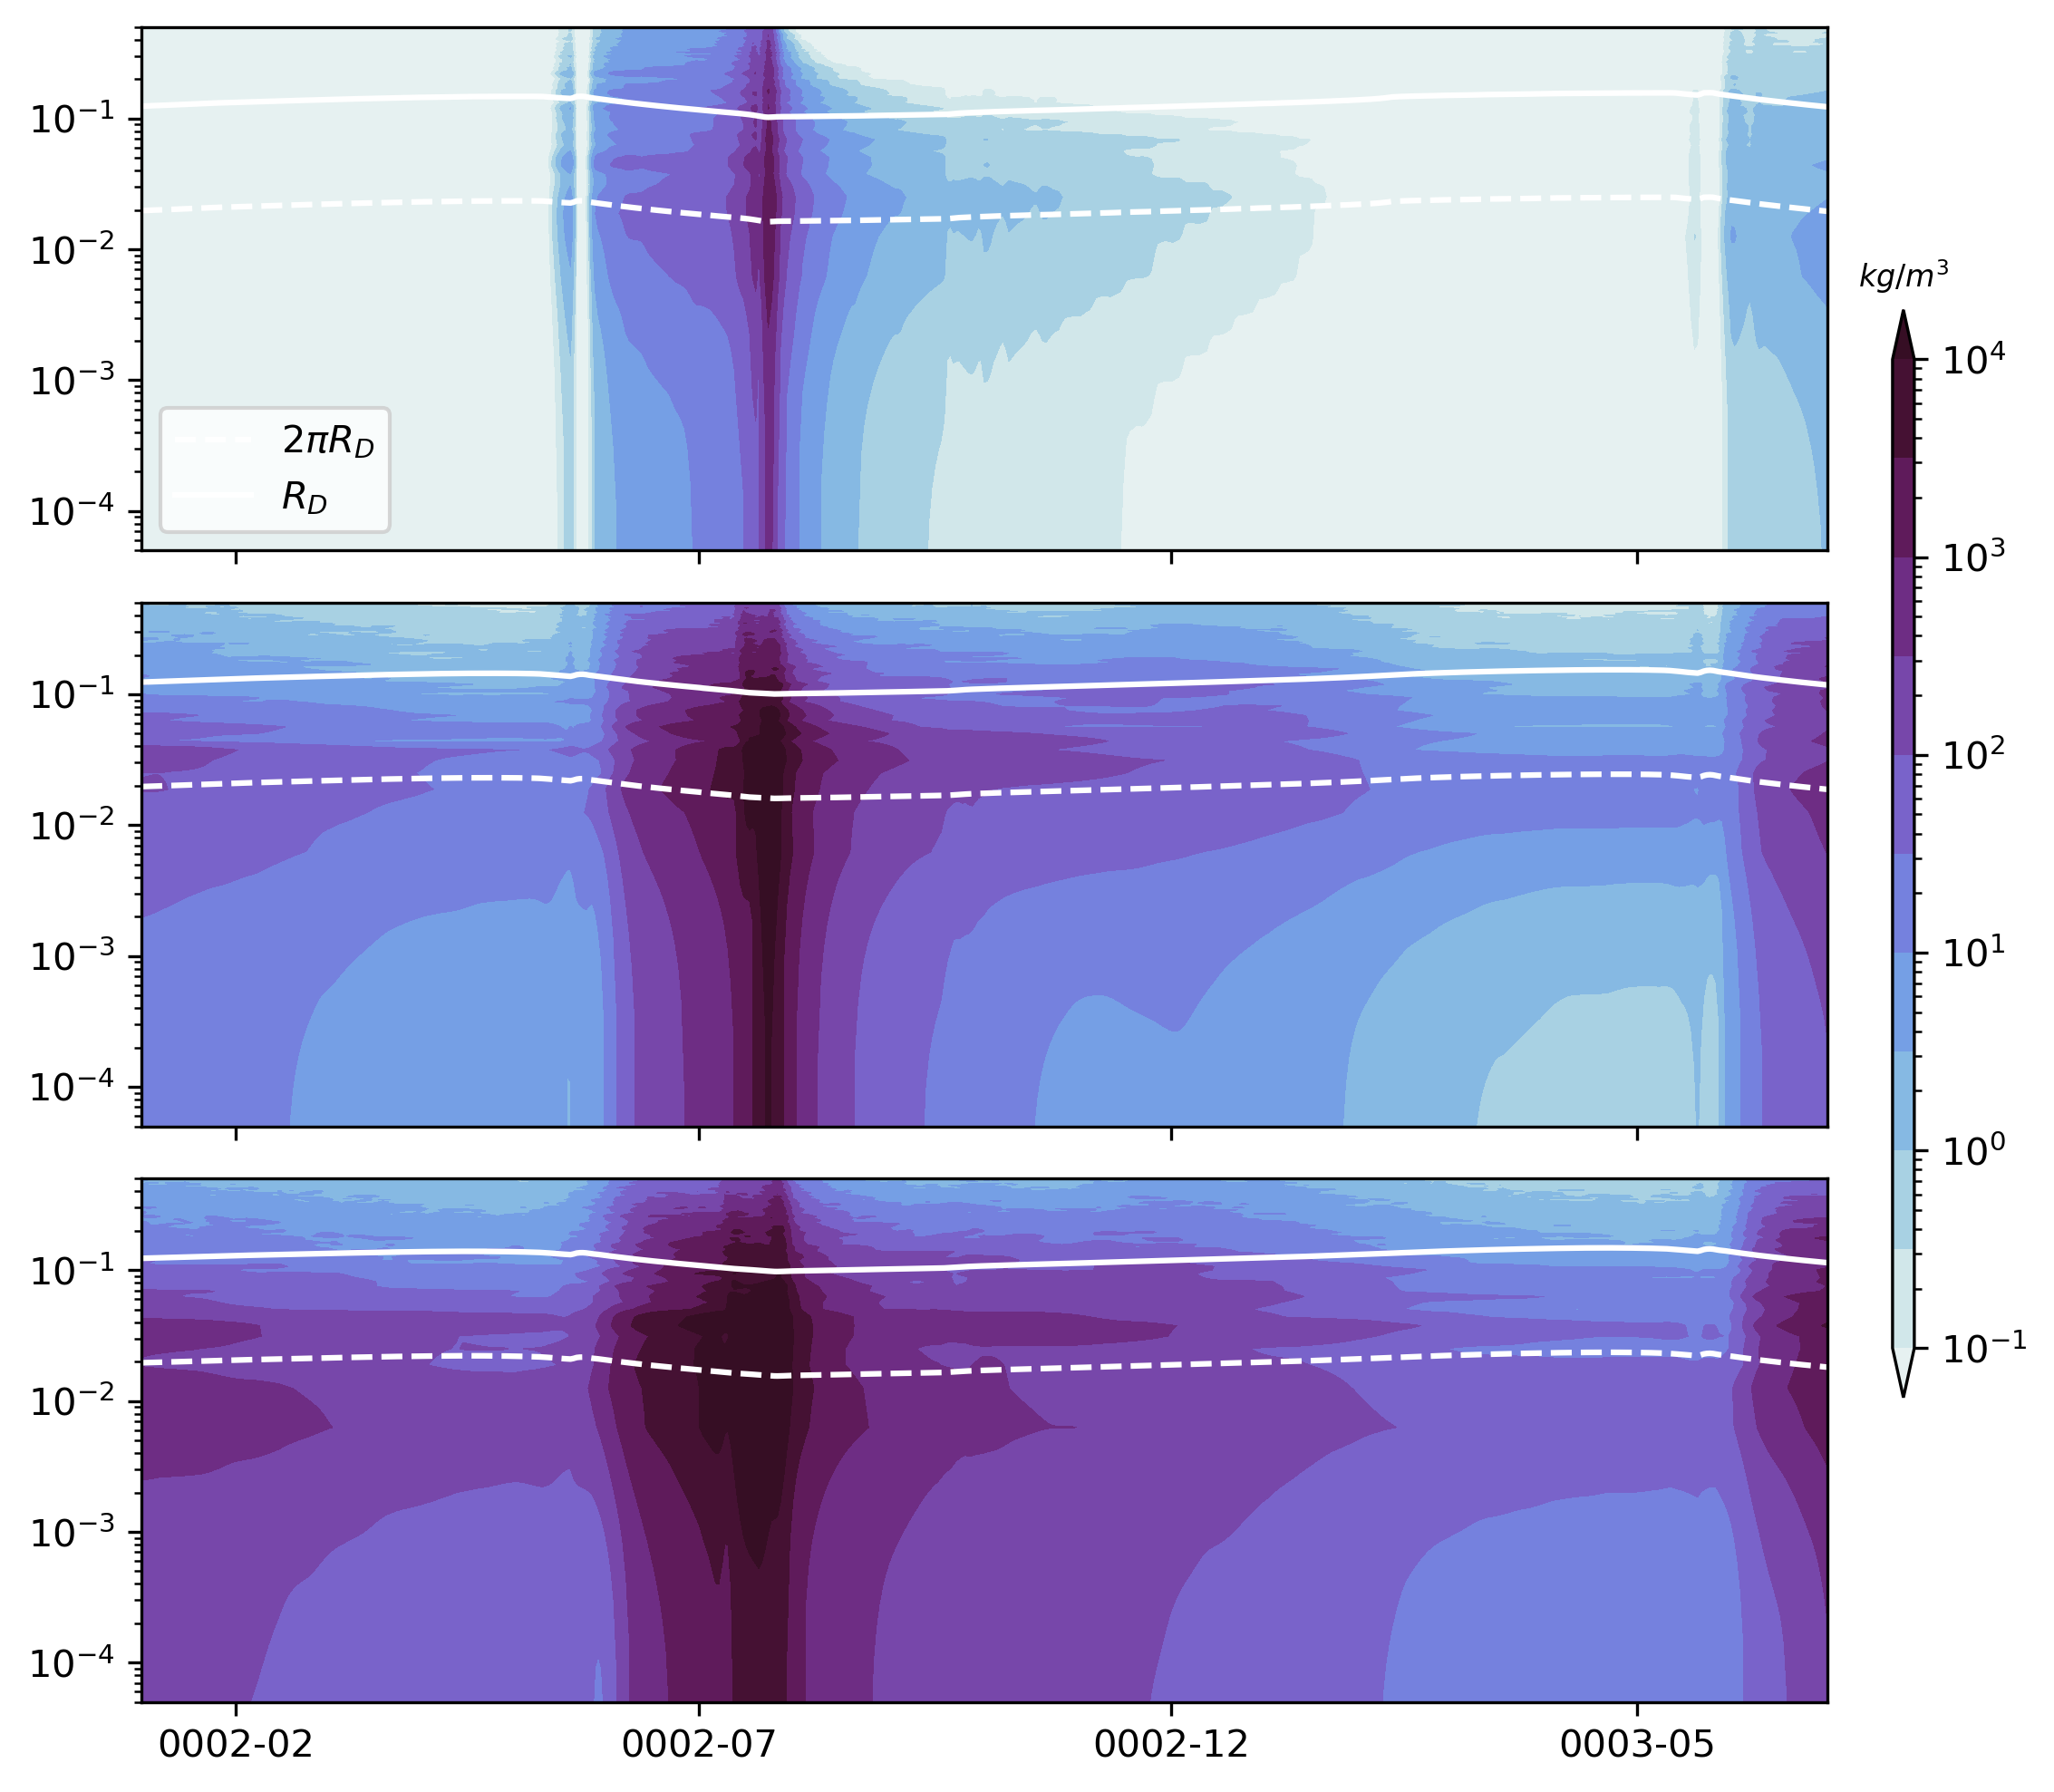

In [34]:
fig, ax = plt.subplots(3,1, figsize=(8,8), dpi=300, sharex=True)

levels= np.logspace(-1,4,11)

cbar = ax[0].contourf(PSD_0.time.values, xaxis.isel(time=0), PSD_0.T, norm=matplotlib.colors.LogNorm(vmin=1e-1,vmax=1e4), levels=levels, extend='both',cmap=cm.cm.dense)
ax[1].contourf(PSD_05.time.values, xaxis.isel(time=0), PSD_05.T, norm=matplotlib.colors.LogNorm(vmin=1e-1,vmax=1e4), levels=levels, extend='both',cmap=cm.cm.dense)
ax[2].contourf(PSD_1.time.values, xaxis.isel(time=0), PSD_1.T, norm=matplotlib.colors.LogNorm(vmin=1e-1,vmax=1e4), levels=levels, extend='both',cmap=cm.cm.dense)


(1/(2*np.pi*RD.R1_0)).plot(x="time_counter", ax=ax[0], color='w', linestyle='--', label='$2\pi R_D$')
(1/(2*np.pi*RD.R1_05)).plot(x="time_counter", ax=ax[1], color='w', linestyle='--')
(1/(2*np.pi*RD.R1_1)).plot(x="time_counter", ax=ax[2], color='w', linestyle='--')

(1/RD.R1_0).plot(x="time_counter", ax=ax[0], color='w', label='$R_D$')
(1/RD.R1_05).plot(x="time_counter", ax=ax[1], color='w')
(1/RD.R1_1).plot(x="time_counter", ax=ax[2], color='w')


ax[0].legend()

# ax.set_xscale('log')
[ a.set_yscale('log') for a in ax.ravel()]
[ a.set_ylim((0.5e-4,0.5)) for a in ax.ravel()]

[ a.set_ylabel('') for a in ax.ravel()]
[ a.set_xlabel('') for a in ax.ravel()]

cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])
fig.colorbar(cbar, cax=cax, orientation='vertical', extend="both")
cax.set_title('$kg/m^3$',fontsize=8)
cbar.colorbar.ax.set_yscale('log')

plt.subplots_adjust(hspace=0.1,wspace=0.1)

# Ice spectra

In [26]:
data = dataset_icemod_3h.isel(y=slice(10,241)).load()

In [27]:
PSD_0 = compute_PSD_dataset_2D(data,'icevolu_front_0','y')

In [28]:
PSD_05 = compute_PSD_dataset_2D(data,'icevolu_front_05_noTf','y')

In [29]:
PSD_1 = compute_PSD_dataset_2D(data,'icevolu_front_1_noTf','y')

In [30]:
PSD_ice = xr.merge([PSD_0,PSD_05,PSD_1])

In [31]:
PSD_ice.to_netcdf(folder+'/postprocessed/spectra_ice.nc')

In [32]:
PSD_ice =xr.open_dataset(folder+'/postprocessed/spectra_ice.nc')

In [33]:
xaxis_ice = PSD_ice["icevolu_front_0_om"].mean('y')*1000
PSD_ice_0 =  PSD_ice["icevolu_front_0_PSD"].mean('y')
PSD_ice_05 =  PSD_ice["icevolu_front_05_noTf_PSD"].mean('y')
PSD_ice_1 =  PSD_ice["icevolu_front_1_noTf_PSD"].mean('y')

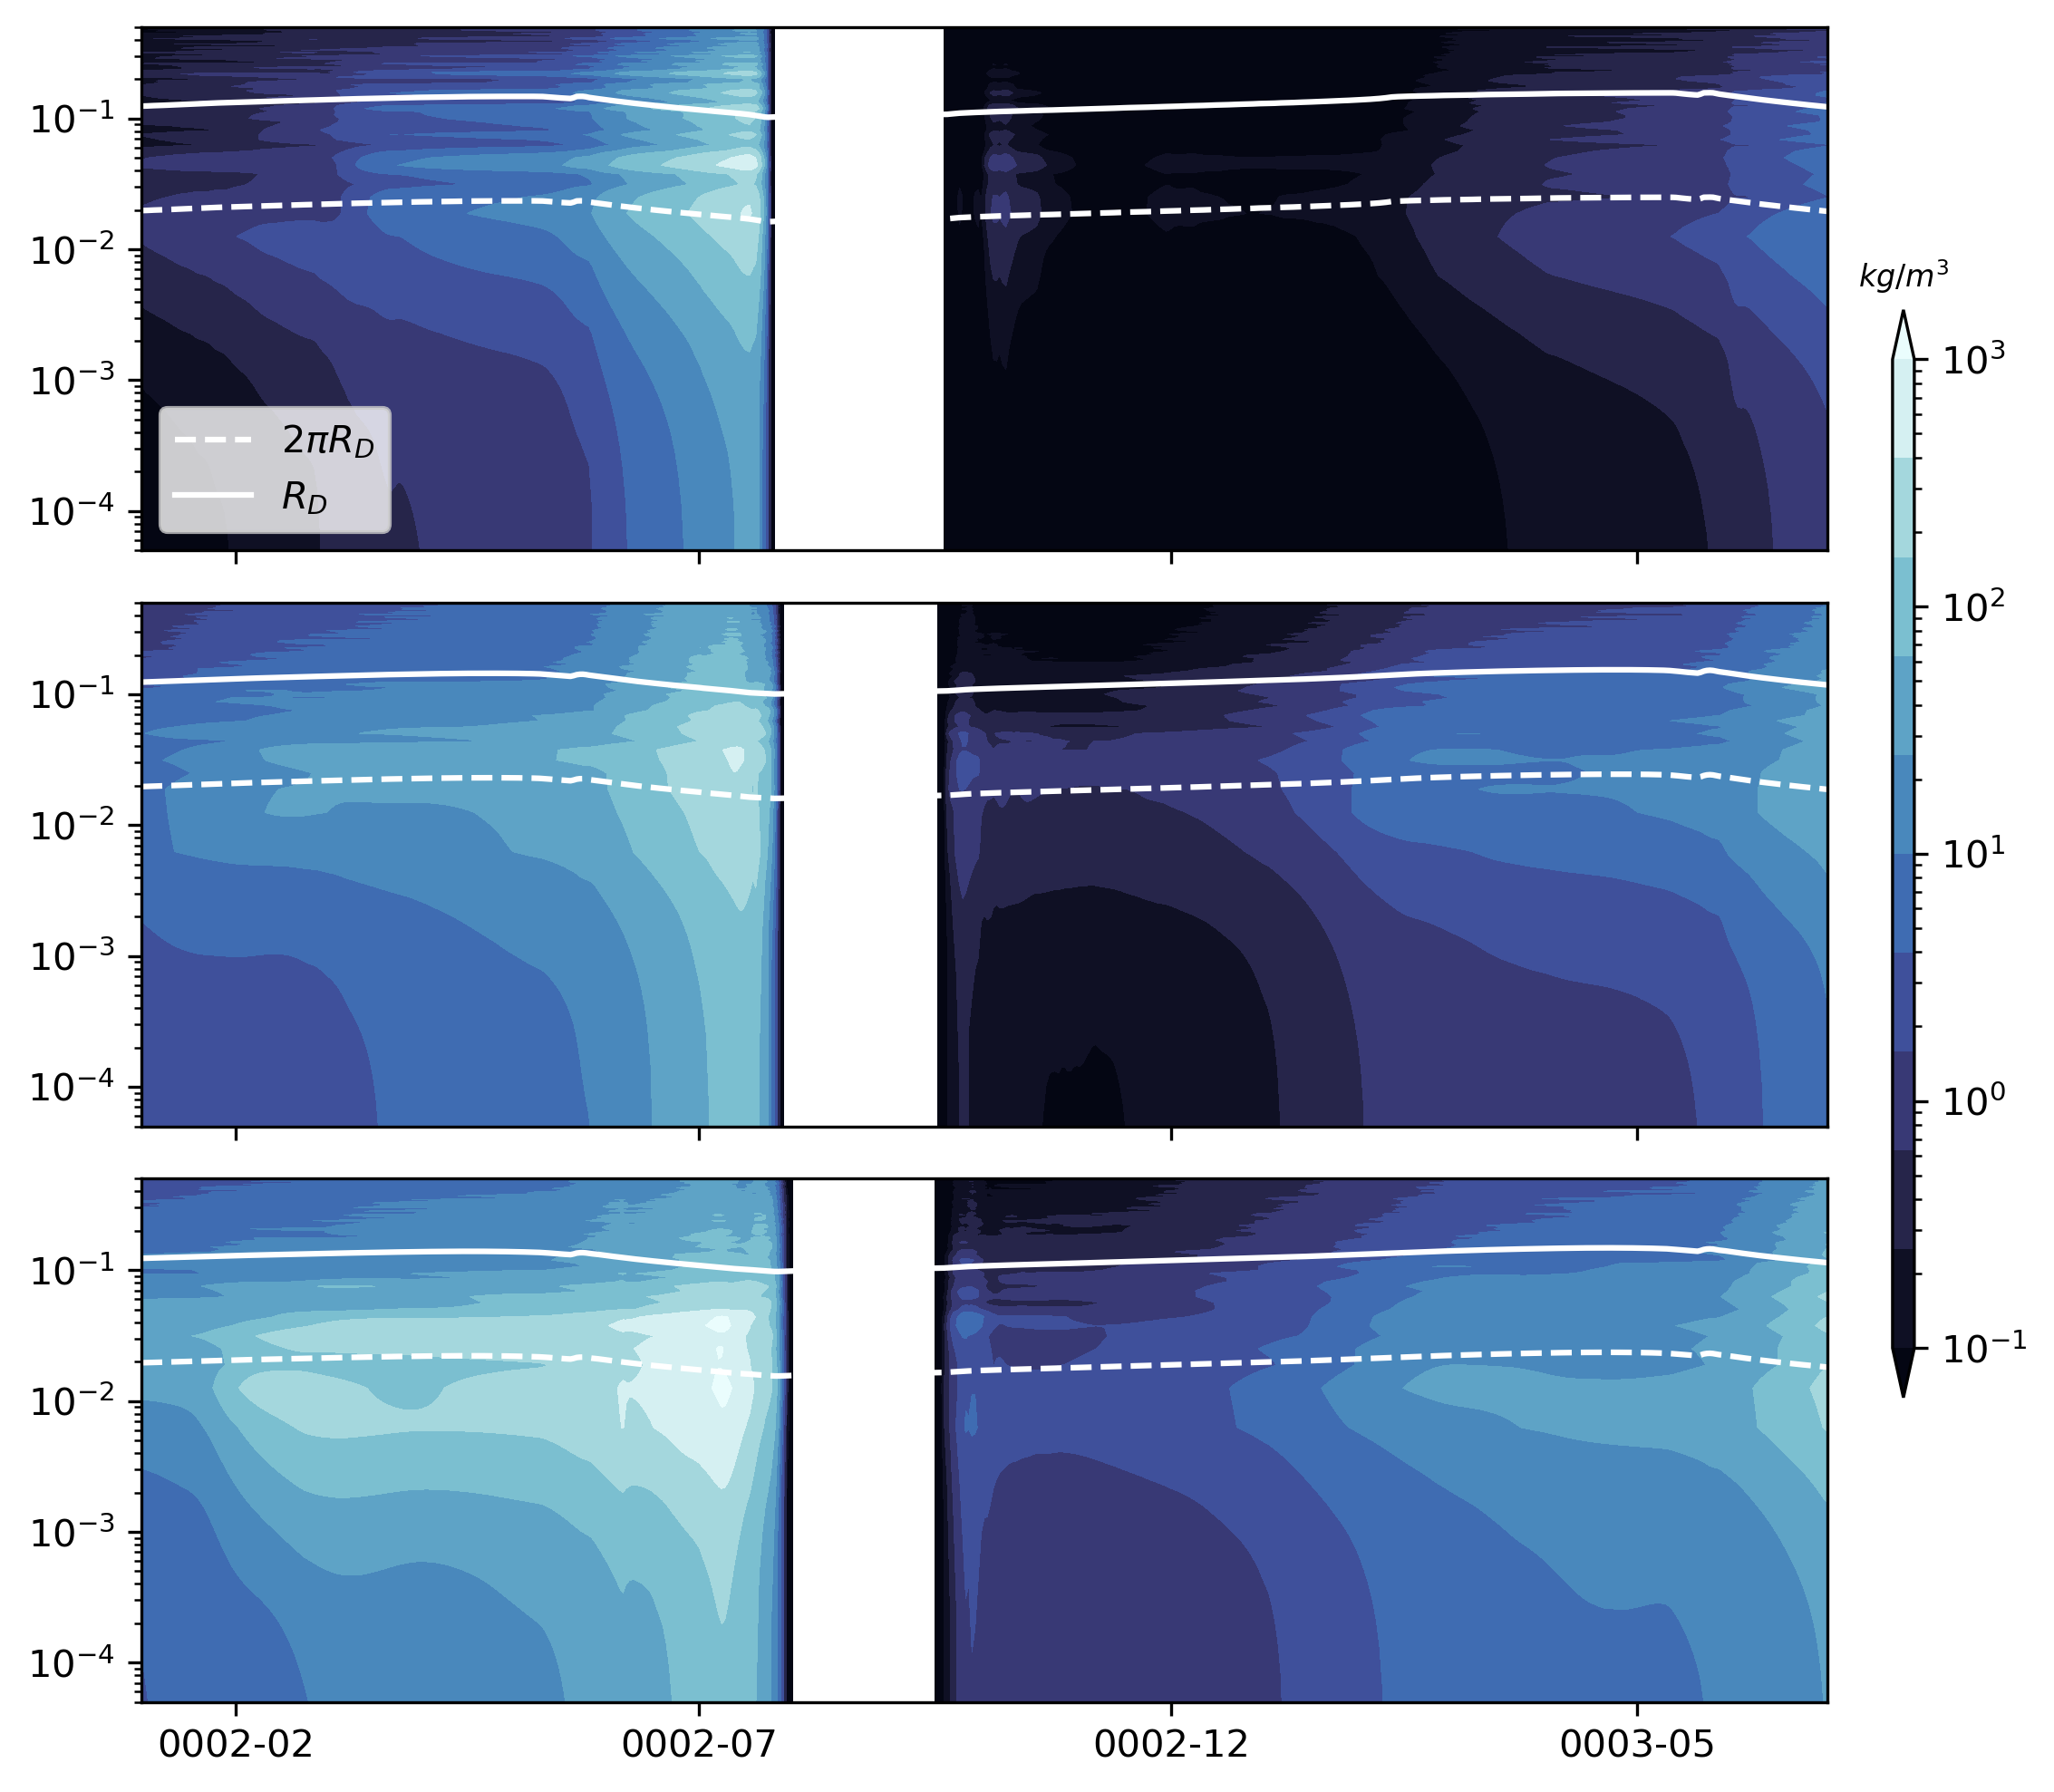

In [34]:
fig, ax = plt.subplots(3,1, figsize=(8,8), dpi=300, sharex=True)

levels= np.logspace(-1,3,11)

cbar = ax[0].contourf(PSD_ice_0.time.values, xaxis_ice.isel(time=0), PSD_ice_0.T, norm=matplotlib.colors.LogNorm(vmin=1e-1,vmax=1e3), levels=levels, extend='both',cmap=cm.cm.ice)
ax[1].contourf(PSD_ice_05.time.values, xaxis_ice.isel(time=0), PSD_ice_05.T, norm=matplotlib.colors.LogNorm(vmin=1e-1,vmax=1e3), levels=levels, extend='both',cmap=cm.cm.ice)
ax[2].contourf(PSD_ice_1.time.values, xaxis_ice.isel(time=0), PSD_ice_1.T, norm=matplotlib.colors.LogNorm(vmin=1e-1,vmax=1e3), levels=levels, extend='both',cmap=cm.cm.ice)


(1/(2*np.pi*RD.R1_0)).plot(x="time_counter", ax=ax[0], color='w', linestyle='--', label='$2\pi R_D$')
(1/(2*np.pi*RD.R1_05)).plot(x="time_counter", ax=ax[1], color='w', linestyle='--')
(1/(2*np.pi*RD.R1_1)).plot(x="time_counter", ax=ax[2], color='w', linestyle='--')

(1/RD.R1_0).plot(x="time_counter", ax=ax[0], color='w', label='$R_D$')
(1/RD.R1_05).plot(x="time_counter", ax=ax[1], color='w')
(1/RD.R1_1).plot(x="time_counter", ax=ax[2], color='w')


ax[0].legend()

# ax.set_xscale('log')
[ a.set_yscale('log') for a in ax.ravel()]
[ a.set_ylim((0.5e-4,0.5)) for a in ax.ravel()]

[ a.set_ylabel('') for a in ax.ravel()]
[ a.set_xlabel('') for a in ax.ravel()]

cax = fig.add_axes([0.93, 0.25, 0.01, 0.5])
fig.colorbar(cbar, cax=cax, orientation='vertical', extend="both")
cax.set_title('$kg/m^3$',fontsize=8)
cbar.colorbar.ax.set_yscale('log')

plt.subplots_adjust(hspace=0.1,wspace=0.1)